# Pruning ResNet18 (CIFAR10 Dataset)
### 1. Pruning by percentage
### 2. Finetune pruned model
### 3. Iterative Pruning
### 4. Global iterative pruning
The purpose of the notebook is to demonstrate pruning of a deep learning model (ResNet in this example). Pruning reduces the number of parameters in a model by removing less important (by setting low magnitude weights to zero). There are three main purposes of pruning:
1. Reduce Model Size
Memory Efficiency: With less parameters, pruning decreases the memory required to store the model. This results in a smaller model size, which is beneficial for deploying models on devices with limited memory.
Storage Savings: The model also requires less storage space, making it easier and more efficient to save and load.
2. Improve Computational Efficiency
Reduced Computational Load: Pruning decreases the number of operations required during both training and inference, leading to improved computational efficiency and potentially faster execution.
3. Lower Power Consumption
Energy Efficiency: Models with fewer parameters require less computational power, which translates to lower energy consumption.
Optimized Hardware Utilization: Reduced model size and complexity can lead to more efficient utilization of hardware resources, further contributing to lower power usage.e.

In [46]:
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = None
    if stride==2:
      self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

  def forward(self, x):
    res = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    if self.downsample is not None:
      res = self.downsample(x)
    out += res
    out = F.relu(out)
    return out

class ResNet20(nn.Module):
  def __init__(self, resblock, n=3):
    super(ResNet20, self).__init__()
    self.n = n
    self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.avgpool = nn.AvgPool2d(8)
    self.fc1   = nn.Linear(64, 10)
    self.layer1 = self.create_layer(resblock, 16, 16, stride=1)
    self.layer2 = self.create_layer(resblock, 16, 32, stride=2)
    self.layer3 = self.create_layer(resblock, 32, 64, stride=2)

  def create_layer(self, resblock, in_channels, out_channels, stride):
    layers = nn.ModuleList()
    layers.append(resblock(in_channels, out_channels, stride))
    for i in range(self.n-1):
      layers.append(resblock(out_channels, out_channels, stride=1))
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = F.relu(out)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    return out

In [68]:
import torch.nn as nn
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(size=(32, 32), padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])

CIFAR10_train = torchvision.datasets.CIFAR10(root='CIFAR10_data/',
                                   train=True,
                                   transform=train_transform,
                                   download=True)

CIFAR10_test = torchvision.datasets.CIFAR10(root='CIFAR10_data/',
                         train=False,
                         transform=test_transform,
                         download=True)
BATCH_SIZE = 100

train_loader = torch.utils.data.DataLoader(
    dataset=CIFAR10_train, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=CIFAR10_test, batch_size=BATCH_SIZE, shuffle=False)

def test_CIFAR10(model, test_loader, device, verbose=True):
    criterion = torch.nn.CrossEntropyLoss().to(device)
    model.eval()
    total_examples = 0
    correct_examples = 0
    total_test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            out = model(inputs)
            loss = criterion(out, targets)
            total_test_loss += loss.item()
            _, predicted = torch.max(out, 1)
            total_examples += targets.size(0)
            correct_examples += (predicted == targets).sum().item()
    test_avg_acc = correct_examples / total_examples
    test_avg_loss = total_test_loss / len(test_loader)
    if verbose:
        print("Test accuracy: %.4f" % (test_avg_acc))
        print("Test loss: %.4f" % (test_avg_loss))
    return test_avg_acc, test_avg_loss
    
def plot_acc(x, acc, x_label, y_label, title):
    plt.figure(figsize=(8, 6))
    plt.plot(x, acc, 'b-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


Here, we load a pretrained resnet (model from ResNet notebook, trained for 200 epochs). We see that the pretrained accuracy without any modification to the weights on the CIFAR10 test set is 84.4%.

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet20(ResidualBlock).to(device)
model.load_state_dict(torch.load("resnet.pth")['state_dict'])
test_CIFAR10(model, test_loader, device)

Test accuracy: 0.8442
Test loss: 0.6961


(0.8442, 0.6960620328783989)

## Pruning by percentage

Now, we will prune the pretrained model's weight by percentage.

In [49]:
import numpy as np

def prune_by_percentage(layer, q=70.0):
    numpy_weight = layer.weight.cpu().detach().numpy()
    qth_percentile = np.percentile(np.abs(numpy_weight), q)
    binary_mask = np.abs(numpy_weight) > qth_percentile
    binary_mask_tensor = torch.from_numpy(binary_mask).to(device)
    layer.weight.data *= binary_mask_tensor

def test_prune_by_percentage(model, q):
    for name,layer in model.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
            prune_by_percentage(layer, q)

In [53]:
q_vals = [10, 20, 30, 40, 50, 60, 70, 80, 90]
accuracies = []
for q in q_vals:
    model.load_state_dict(torch.load("resnet.pth")['state_dict'])
    test_prune_by_percentage(model, q)
    accuracies.append(test_CIFAR10(model, test_loader, device, verbose=False)[0])

As expected, we see that pruning the pretained model results in decrease in test accuracy. But it is still interesting how the model accuracy is still high even after pruning 50% of the weights. There is a sharp drop after pruning more than 60% of the weights.

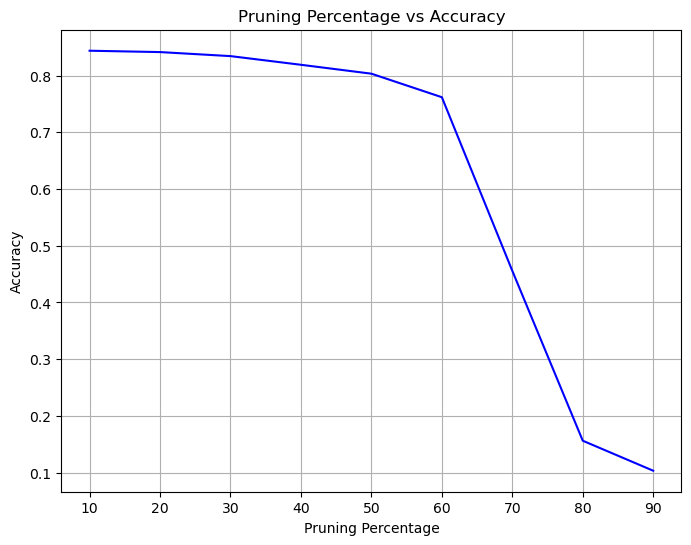

In [55]:
plot_acc(q_vals, accuracies, 'Pruning Percentage', 'Accuracy', 'Pruning Percentage vs Accuracy')

## Finetune pruned model

Now, we will finetune our pruned model. We will use the 70% pruned model, which showed ~45% test accuracy.

In [84]:
def finetune_after_prune(model, trainloader, criterion, optimizer, prune=True):
    # Map for nonzero weights
    weight_mask = {}
    for name, layer in model.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
            # 1 for nonzero element and 0 for zero element 
            weight_mask[name] = layer.weight.cpu().detach().numpy() != 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if prune:
            for name, layer in model.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
                    # Use mask to keep pruned weights 0
                    layer.weight.data *= torch.from_numpy(weight_mask[name]).to(device)
        _, predicted = outputs.max(1)

In [85]:
model.load_state_dict(torch.load("resnet.pth")['state_dict'])
test_prune_by_percentage(model, 70)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

accs = []

# Re-train 70% pruned model for 20 epochs
for epoch in range(20):
    model.train()
    finetune_after_prune(model, train_loader, criterion, optimizer)
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct / total
    accs.append(acc)
    if epoch % 5 == 0:
        print('\nEpoch: %d' % epoch)
        print("Test Loss=%.4f, Test acc=%.4f" % (loss / len(test_loader), acc))


Epoch: 0
Test Loss=0.0121, Test acc=0.8028

Epoch: 5
Test Loss=0.0094, Test acc=0.8303

Epoch: 10
Test Loss=0.0087, Test acc=0.8386

Epoch: 15
Test Loss=0.0081, Test acc=0.8456


We have finetuned our 70% pruned model for 20 epochs. Let's make sure that the finetuned model is still pruned to 70%.

In [89]:
for name, layer in model.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
        np_weight = layer.weight.cpu().detach().numpy()
        zeros = np.count_nonzero(np_weight==0)
        total = np_weight.size
        print('Sparsity of '+ name + ': ' + str(zeros/total))

Sparsity of conv1: 0.6990740740740741
Sparsity of fc1: 0.7
Sparsity of layer1.0.conv1: 0.7000868055555556
Sparsity of layer1.0.conv2: 0.7000868055555556
Sparsity of layer1.1.conv1: 0.7000868055555556
Sparsity of layer1.1.conv2: 0.7000868055555556
Sparsity of layer1.2.conv1: 0.7000868055555556
Sparsity of layer1.2.conv2: 0.7000868055555556
Sparsity of layer2.0.conv1: 0.6998697916666666
Sparsity of layer2.0.conv2: 0.6999782986111112
Sparsity of layer2.1.conv1: 0.6999782986111112
Sparsity of layer2.1.conv2: 0.6999782986111112
Sparsity of layer2.2.conv1: 0.6999782986111112
Sparsity of layer2.2.conv2: 0.6999782986111112
Sparsity of layer3.0.conv1: 0.6999782986111112
Sparsity of layer3.0.conv2: 0.7000054253472222
Sparsity of layer3.1.conv1: 0.7000054253472222
Sparsity of layer3.1.conv2: 0.7000054253472222
Sparsity of layer3.2.conv1: 0.7000054253472222
Sparsity of layer3.2.conv2: 0.7000054253472222


We have successfully finetuned our 70% pruned ResNet18 model. We were able to increase the model accuracy from 45% to 84.5% while maintaining pruning of the overall model.

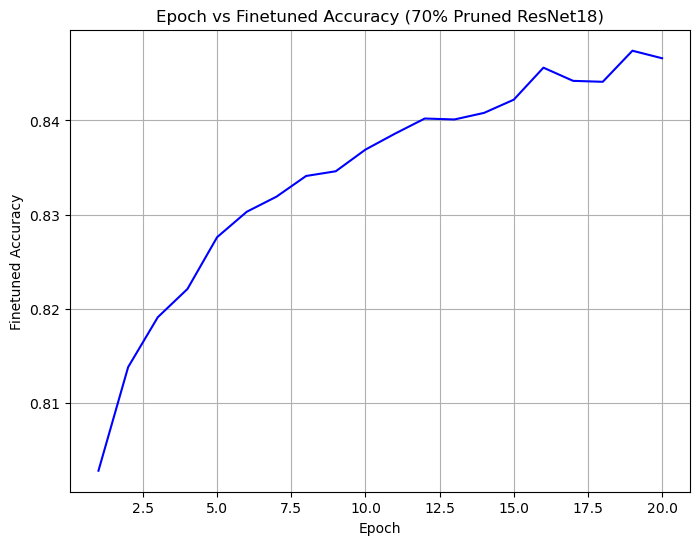

In [86]:
plot_acc(np.arange(20)+1, accs, 'Epoch', 'Finetuned Accuracy', 'Epoch vs Finetuned Accuracy (70% Pruned ResNet18)')

## Iterative pruning

Instead of performing a single-step pruning followed by fine-tuning, we will try gradually increasing the model's sparsity before each fine-tuning epoch. Linearly raise the pruning percentage over 10 epochs, reaching 70% sparsity in the final epoch. After achieving the desired sparsity, we continue fine-tuning the model for an additional 10 epochs.

In [101]:
model.load_state_dict(torch.load("resnet.pth")['state_dict'])

accs = []

for epoch in range(20):
    model.train()
    if epoch < 10:
        for name, layer in model.named_modules():
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
                q = 7*(epoch + 1)
                prune_by_percentage(layer, q=q)
    if epoch < 9:
        finetune_after_prune(model, train_loader, criterion, optimizer, prune=False)
    else:
        finetune_after_prune(model, train_loader, criterion, optimizer)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct / total
    accs.append(acc)
    if epoch % 5 == 0:
        print('\nEpoch: %d' % epoch)
        print("Test Loss=%.4f, Test acc=%.4f" % (loss / len(test_loader), acc))


Epoch: 0
Test Loss=0.0059, Test acc=0.8446

Epoch: 5
Test Loss=0.0044, Test acc=0.8496

Epoch: 10
Test Loss=0.0043, Test acc=0.8341

Epoch: 15
Test Loss=0.0043, Test acc=0.8407


Again, let's make sure that our model remains 70% pruned.

In [102]:
for name, layer in model.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
        np_weight = layer.weight.cpu().detach().numpy()
        zeros = np.count_nonzero(np_weight==0)
        total = np_weight.size
        print('Sparsity of '+ name + ': ' + str(zeros/total))

Sparsity of conv1: 0.6990740740740741
Sparsity of fc1: 0.7
Sparsity of layer1.0.conv1: 0.7000868055555556
Sparsity of layer1.0.conv2: 0.7000868055555556
Sparsity of layer1.1.conv1: 0.7000868055555556
Sparsity of layer1.1.conv2: 0.7000868055555556
Sparsity of layer1.2.conv1: 0.7000868055555556
Sparsity of layer1.2.conv2: 0.7000868055555556
Sparsity of layer2.0.conv1: 0.6998697916666666
Sparsity of layer2.0.conv2: 0.6999782986111112
Sparsity of layer2.1.conv1: 0.6999782986111112
Sparsity of layer2.1.conv2: 0.6999782986111112
Sparsity of layer2.2.conv1: 0.6999782986111112
Sparsity of layer2.2.conv2: 0.6999782986111112
Sparsity of layer3.0.conv1: 0.6999782986111112
Sparsity of layer3.0.conv2: 0.7000054253472222
Sparsity of layer3.1.conv1: 0.7000054253472222
Sparsity of layer3.1.conv2: 0.7000054253472222
Sparsity of layer3.2.conv1: 0.7000054253472222
Sparsity of layer3.2.conv2: 0.7000054253472222


Iteratively pruning results in a slightly improved accuracy.

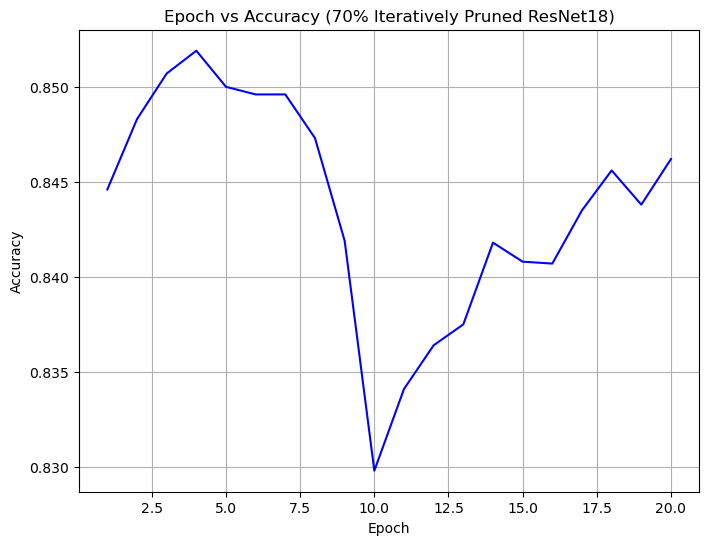

In [104]:
plot_acc(np.arange(20)+1, accs, 'Epoch', 'Accuracy', 'Epoch vs Accuracy (70% Iteratively Pruned ResNet18)')

## Global iterative pruning

In [95]:
def global_prune_by_percentage(model, q=70.0):
    flattened_weights = []
    for name, layer in model.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
            np_weight = layer.weight.cpu().detach().numpy()
            flattened_weights.append(np_weight.flatten())
    flattened_weights = np.concatenate(flattened_weights)
    thres = np.percentile(np.abs(flattened_weights), q)
    
    for name, layer in model.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
            np_weight = layer.weight.cpu().detach().numpy()
            binary_mask = np.abs(np_weight) > thres
            binary_mask_tensor = torch.from_numpy(binary_mask).to(device)
            layer.weight.data *= binary_mask_tensor

In [98]:
model.load_state_dict(torch.load("resnet.pth")['state_dict'])
accs = []

for epoch in range(20):
    model.train()
    if epoch < 10:
        q = 7*(epoch + 1)
        global_prune_by_percentage(model, q=q)
    if epoch < 9:
        finetune_after_prune(model, train_loader, criterion, optimizer, prune=False)
    else:
        finetune_after_prune(model, train_loader, criterion, optimizer)
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct / total
    accs.append(acc)
    if epoch % 5 == 0:
        print('\nEpoch: %d' % epoch)
        print("Test Loss=%.4f, Test acc=%.4f" % (loss / len(test_loader), acc))


Epoch: 0
Test Loss=0.0056, Test acc=0.8466

Epoch: 5
Test Loss=0.0038, Test acc=0.8522

Epoch: 10
Test Loss=0.0040, Test acc=0.8415

Epoch: 15
Test Loss=0.0039, Test acc=0.8470


Let's examine the pruning distribution across our layers. The FC layer has the lowest pruning, and the last convolution layer is nearly 97% pruned. Yet, we see that our model achieves ~85% accuracy.

In [99]:
for name, layer in model.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'downsample' not in name:
        np_weight = layer.weight.cpu().detach().numpy()
        zeros = np.count_nonzero(np_weight==0)
        total = np_weight.size
        print('Sparsity of '+ name + ': ' + str(zeros/total))

Sparsity of conv1: 0.32407407407407407
Sparsity of fc1: 0.1359375
Sparsity of layer1.0.conv1: 0.6614583333333334
Sparsity of layer1.0.conv2: 0.5920138888888888
Sparsity of layer1.1.conv1: 0.6488715277777778
Sparsity of layer1.1.conv2: 0.5750868055555556
Sparsity of layer1.2.conv1: 0.5993923611111112
Sparsity of layer1.2.conv2: 0.5594618055555556
Sparsity of layer2.0.conv1: 0.5119357638888888
Sparsity of layer2.0.conv2: 0.5386284722222222
Sparsity of layer2.1.conv1: 0.7042100694444444
Sparsity of layer2.1.conv2: 0.6768663194444444
Sparsity of layer2.2.conv1: 0.6917317708333334
Sparsity of layer2.2.conv2: 0.6843532986111112
Sparsity of layer3.0.conv1: 0.5403645833333334
Sparsity of layer3.0.conv2: 0.6098090277777778
Sparsity of layer3.1.conv1: 0.6414388020833334
Sparsity of layer3.1.conv2: 0.7438422309027778
Sparsity of layer3.2.conv1: 0.7418348524305556
Sparsity of layer3.2.conv2: 0.9668782552083334


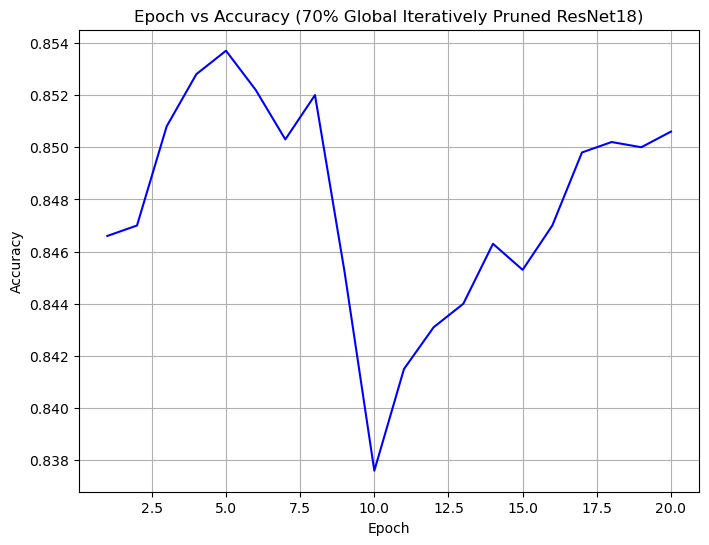

In [100]:
plot_acc(np.arange(20)+1, accs, 'Epoch', 'Accuracy', 'Epoch vs Accuracy (70% Global Iteratively Pruned ResNet18)')